In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [22]:
meta_data = pd.read_csv('Data/meta_data.csv')

In [81]:
meta_data.head(15)

,ID,ACTIVATED,IN_REPAIR_SYSTEM,STILL_ALIVE,Lifetime
0,0,1/31/2019,NaN,True,593
1,1,12/4/2018,NaN,True,651
2,2,4/18/2019,NaN,True,516
3,3,3/5/2019,NaN,True,560
4,4,12/6/2018,NaN,True,649
5,5,3/20/2019,NaN,True,545
6,6,4/24/2019,NaN,True,510
7,7,7/9/2019,NaN,True,434
8,8,12/12/2018,NaN,True,643
9,9,6/14/2019,NaN,True,459


In [23]:
meta_data.describe()

,ID,Lifetime
count,1027.000000,1027.000000
mean,513.000000,531.314508
std,296.613666,92.324199
min,0.000000,401.000000
25%,256.500000,453.000000
50%,513.000000,519.000000
75%,769.500000,592.500000
max,1026.000000,761.000000


In [24]:
data = []

In [25]:
def get_data(N):
    data = []
    
    path = f"{N}.npz"
    path = os.path.join("Data/npz/", path)
    
    bat_files = np.load(path)
    bat_files.files
    
    for bat_file in bat_files['arr_0']:
        data.append(bat_file)
    
    return data

In [26]:
data = get_data(N = 256)

In [82]:
data

[array([ 1.55178538e+09, -4.89662013e-01,  1.42155489e+01,  3.61249714e+01]),
 array([ 1.55178544e+09, -4.82185092e-01,  1.42155489e+01,  3.61249714e+01]),
 array([ 1.55178550e+09, -4.76539254e-01,  1.42106661e+01,  3.61249714e+01]),
 array([ 1.55178556e+09, -4.69062333e-01,  1.42106661e+01,  3.61249714e+01]),
 array([ 1.55178562e+09, -4.69062333e-01,  1.42155489e+01,  3.61249714e+01]),
 array([ 1.55178568e+09, -4.85923552e-01,  1.42155489e+01,  3.61249714e+01]),
 array([ 1.55178574e+09, -4.65323873e-01,  1.42106661e+01,  3.61249714e+01]),
 array([ 1.55178580e+09, -4.61585412e-01,  1.42106661e+01,  3.61249714e+01]),
 array([ 1.55178586e+09, -4.57770657e-01,  1.42106661e+01,  3.61249714e+01]),
 array([ 1.55178592e+09, -4.54032197e-01,  1.42106661e+01,  3.61249714e+01]),
 array([ 1.55178598e+09, -4.29617762e-01,  1.42106661e+01,  3.63744564e+01]),
 array([ 1.55178604e+09, -4.91569390e-01,  1.42106661e+01,  3.63744564e+01]),
 array([ 1.55178610e+09, -4.44647898e-01,  1.42055390e+01,  3.63

In [27]:
# Time-stamps.

t = []
for row in data:
    t.append(row[0])

In [28]:
# Current Data.

C = []
for row in data:
    C.append(row[1])

In [29]:
# Voltage Data.

V = []
for row in data:
    V.append(row[2])

In [30]:
# Temperature Data.

T = []
for row in data:
    T.append(row[3])

In [58]:
X = np.atleast_2d(C[:2000]).T

In [83]:
X

array([[-0.48966201],
       [-0.48218509],
       [-0.47653925],
       ...,
       [-1.34531167],
       [-1.38475624],
       [-1.31151293]])

In [59]:
y = V[:2000]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [61]:
# Create a Gaussian Process Regressor with a Wiener Velocity kernel
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) \
        + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e+1))

In [62]:
# Define the Gaussian process regressor with alpha=0 (no regularization)
gp = GaussianProcessRegressor(kernel=kernel)

In [63]:
# Fit the Gaussian process to the data
gp.fit(X_train, y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=0.1))

In [64]:
# Estimate beta parameter
beta = 1 / (2 * gp.alpha_)

In [65]:
beta

array([-0.09688594, -0.02713522, -0.10496536, ...,  0.06755793,
        0.14728534,  0.24926014])

In [66]:
# Make predictions on the test data
y_pred, sigma = gp.predict(X_test, return_std = True)

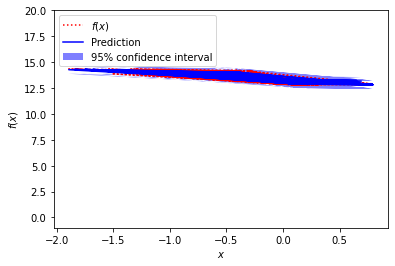

In [67]:
# Plot the results
plt.figure()
plt.plot(X_test, y_test, 'r:', label=u'$f(x)$')
plt.plot(X_test, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([X_test, X_test[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-1, 20)
plt.legend(loc='upper left')
plt.show()

In [71]:
mse = np.mean((y_test - y_pred) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.03875716213819232


In [77]:
Ri = np.mean(beta)
print(Ri)

-1.2703564144474329


In [76]:
Ri = np.sqrt(np.mean(beta**2))
print(Ri)

16.77346408189794


In [79]:
beta.max()

25.968972219532866

In [80]:
beta.min()

-211.38463678826503